In [1]:
################################################################################
################    Classification: Support Vector Machines   ##################
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as mtrs
# Multicolor line
import matplotlib.collections 

from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import preprocessing
import math
import ClassificationTools as CT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [2]:
### Load file --------------------------------------------
df = pd.read_csv('Simdata.dat', sep = "\t")
df.head()

X1        X2    Y
0 -3.745291  3.729409   NO
1  5.806532 -4.703332  YES
2  4.209833 -0.493488  YES
3  3.429156 -2.307669   NO
4 -0.195014  2.680303   NO

In [3]:
### Convert output variable to factor
df.Y = df.Y.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      1000 non-null   float64 
 1   X2      1000 non-null   float64 
 2   Y       1000 non-null   category
dtypes: category(1), float64(2)
memory usage: 16.8 KB


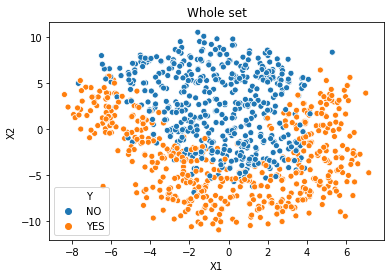

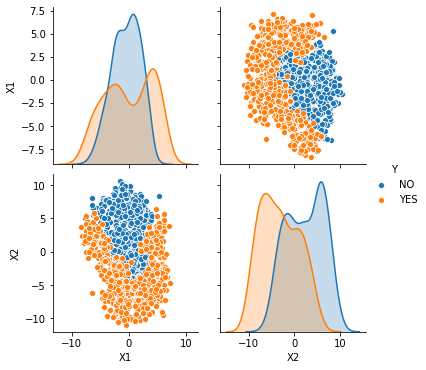

In [4]:
### Exploratory analysis -------------------------------------------------------------------------------------
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = df).set_title("Whole set")
plt.show()
sns.pairplot(df, hue = 'Y')
plt.show()

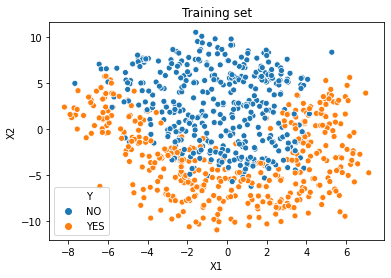

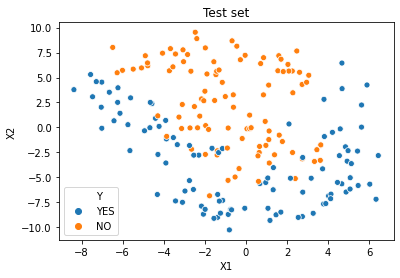

In [5]:
X = df[['X1','X2']]
y = df['Y']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5, stratify = y)

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

## plot training and test sets. 
## Try changing the value inside set.seed(). How does it affect the selected data?
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTR_eval).set_title("Training set")
plt.show()
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTS_eval).set_title("Test set")
plt.show()



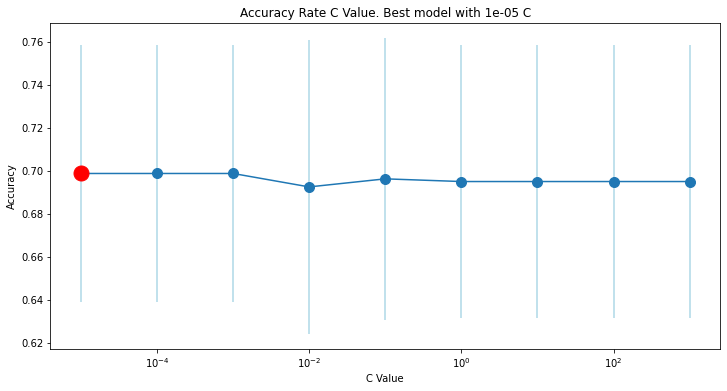

In [6]:
#-------------------------------------------------------------------------------------------------
#------------------------------- LINEAR SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]} # Cost term
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('SVC', SVC(kernel='linear', # lineal kernel
                                   probability=True, # let the model predict probabilities
                                   random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
Linear_SVC_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
Linear_SVC_fit.fit(X_train, y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(Linear_SVC_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = Linear_SVC_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_tree = meanAcc # Store cv-scores for later

plt.figure(figsize=(12, 6))
plt.plot(Linear_SVC_fit.cv_results_['param_SVC__C'], meanAcc, marker='o', markersize=10)
plt.errorbar(Linear_SVC_fit.cv_results_['param_SVC__C'], meanAcc, yerr=stdAcc, linestyle="None", ecolor='lightblue')
plt.plot(Linear_SVC_fit.best_params_['SVC__C'], Linear_SVC_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate C Value. Best model with ' + str(Linear_SVC_fit.best_params_['SVC__C']) + ' C')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()


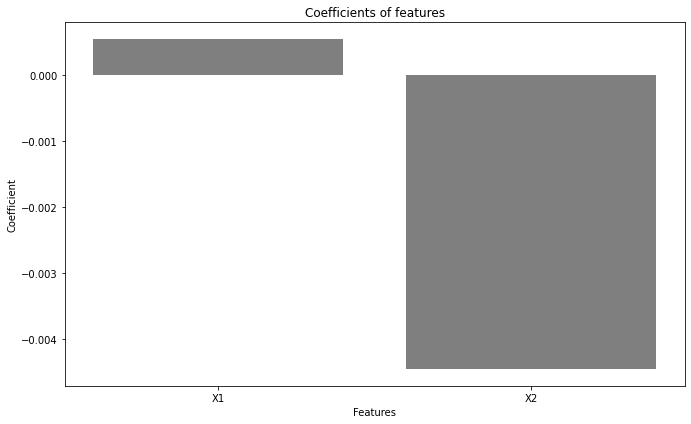

In [7]:
## Plot the variable coefficient of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train.columns))
bar_width = 0.35
plt.bar(index, Linear_SVC_fit.best_estimator_['SVC'].coef_[0,:], color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients of features')
plt.xticks(index, X_train.columns)
plt.tight_layout()
plt.show()

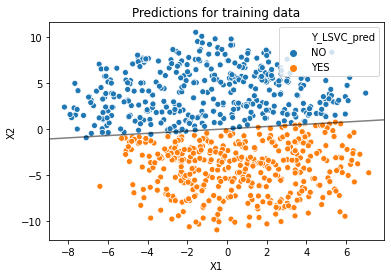

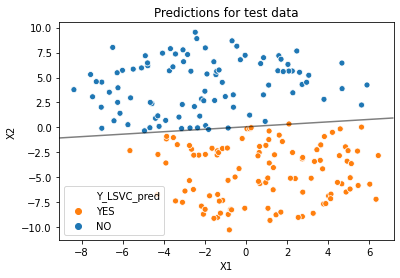

In [8]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_train)
dfTR_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_train)[:,0]
dfTR_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_train)[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_test)
dfTS_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_test)[:,0]
dfTS_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_test)[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_LSVC_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
CT.plot_svc_decision_function(Linear_SVC_fit.best_estimator_['SVC'])
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_LSVC_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
CT.plot_svc_decision_function(Linear_SVC_fit.best_estimator_['SVC'])
plt.show()


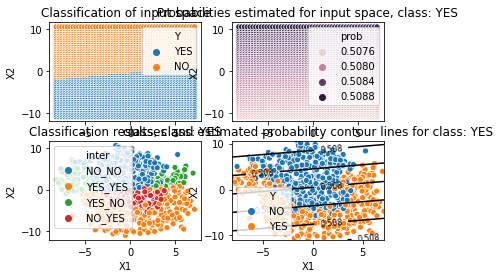

In [9]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train, dfTR_eval['Y'], Linear_SVC_fit, 'X1', 'X2', 'YES', 50) 

In [10]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LSVC_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  273  127
      YES  110  290

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.41
Mcnemar's Test P-Value: 0.3
Sensitivity: 0.72
Specificity: 0.68
Pos pred value: 0.7
Neg pred value: 0.71
Prevalence: 0.5
Detection Rate: 0.36
Detection prevalence: 0.52
Balanced accuracy: 0.7
F Score: 0.71
Positive class: YES


In [11]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LSVC_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   74  26
       NO   33  67

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.41
Mcnemar's Test P-Value: 0.43
Sensitivity: 0.67
Specificity: 0.74
Pos pred value: 0.72
Neg pred value: 0.69
Prevalence: 0.5
Detection Rate: 0.34
Detection prevalence: 0.46
Balanced accuracy: 0.7
F Score: 0.69
Positive class: NO


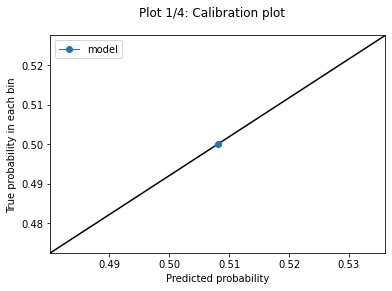

No handles with labels found to put in legend.


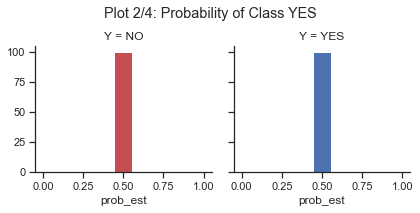

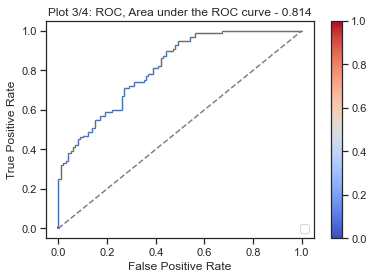

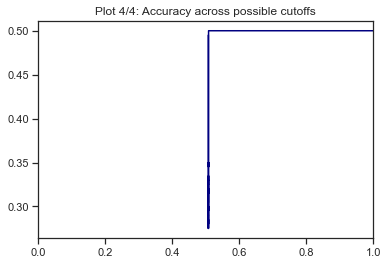

In [12]:
CT.plotClassPerformance(dfTS_eval['Y'], Linear_SVC_fit.predict_proba(X_test)[:,1], selClass='YES')

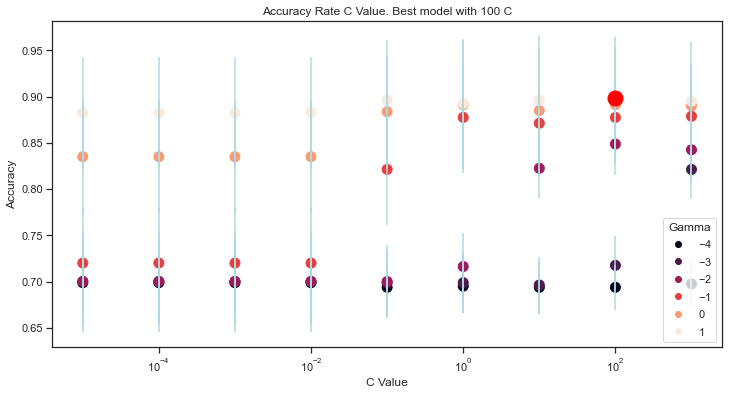

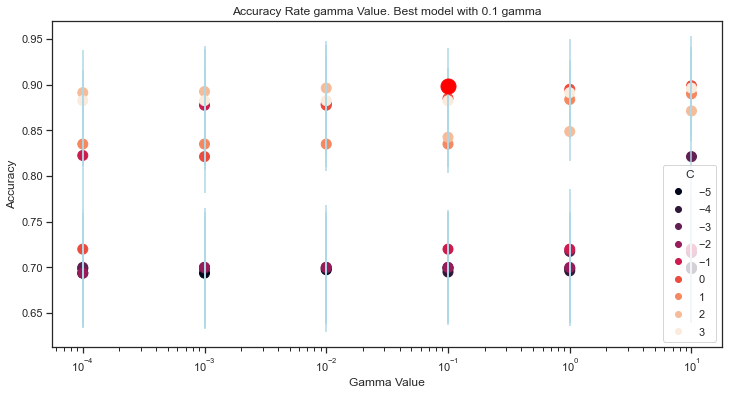

In [24]:
#-------------------------------------------------------------------------------------------------
#------------------------------- RADIAL SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Train model -----------------------------------------------------------------------------------
param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], # Cost term
         'SVC__gamma':[0.0001,0.001,0.01,0.1,1,10]} # Inverse width parameter in the Gaussian Radial Basis kernel 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('SVC', SVC(kernel='rbf', # lineal kernel
                                   probability=True, # let the model predict probabilities
                                   random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
SVC_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
SVC_fit.fit(X_train, y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(SVC_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = SVC_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_tree = meanAcc # Store cv-scores for later

plt.figure(figsize=(12, 6))
plt.errorbar(SVC_fit.cv_results_['param_SVC__C'], 
             [x for _,x in sorted(zip(SVC_fit.cv_results_['param_SVC__C'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(SVC_fit.cv_results_['param_SVC__C'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(SVC_fit.cv_results_['param_SVC__C'], 
            [x for _,x in sorted(zip(SVC_fit.cv_results_['param_SVC__C'],meanAcc))], 
            c=np.log10(np.array(SVC_fit.cv_results_['param_SVC__gamma'], dtype=float)),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Gamma")
plt.plot(SVC_fit.best_params_['SVC__C'], SVC_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate C Value. Best model with ' + str(SVC_fit.best_params_['SVC__C']) + ' C')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

plt.figure(figsize=(12, 6))
plt.errorbar(SVC_fit.cv_results_['param_SVC__gamma'], 
             [x for _,x in sorted(zip(SVC_fit.cv_results_['param_SVC__gamma'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(SVC_fit.cv_results_['param_SVC__gamma'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(SVC_fit.cv_results_['param_SVC__gamma'], 
            [x for _,x in sorted(zip(SVC_fit.cv_results_['param_SVC__gamma'],meanAcc))], 
            c=np.log10(np.array(SVC_fit.cv_results_['param_SVC__C'], dtype=float)),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="C")
plt.plot(SVC_fit.best_params_['SVC__gamma'], SVC_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate gamma Value. Best model with ' + str(SVC_fit.best_params_['SVC__gamma']) + ' gamma')
plt.xlabel('Gamma Value')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()



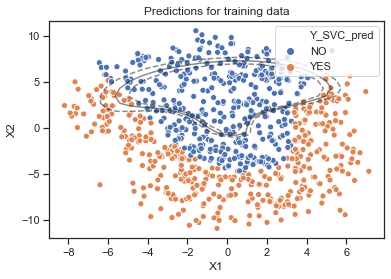

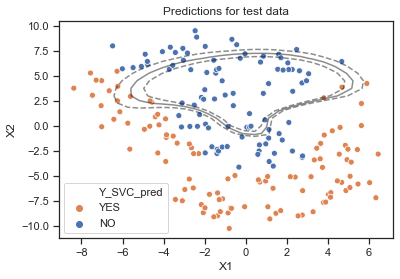

In [25]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_SVC_pred'] = SVC_fit.predict(X_train)
dfTR_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_train)[:,0]
dfTR_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_train)[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_SVC_pred'] = SVC_fit.predict(X_test)
dfTS_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_test)[:,0]
dfTS_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_test)[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_SVC_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
CT.plot_svc_decision_function(SVC_fit.best_estimator_['SVC'])
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_SVC_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
CT.plot_svc_decision_function(SVC_fit.best_estimator_['SVC'])
plt.show()

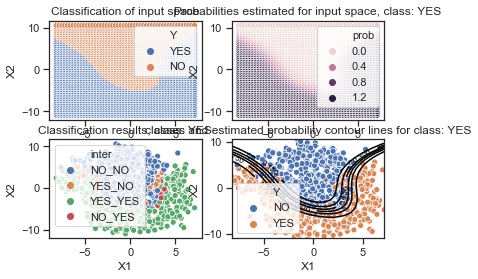

In [26]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train, dfTR_eval['Y'], SVC_fit, 'X1', 'X2', 'YES', 50) 

In [27]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_SVC_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  360   40
      YES   39  361

Accuracy: 0.9
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.8
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.9
Specificity: 0.9
Pos pred value: 0.9
Neg pred value: 0.9
Prevalence: 0.5
Detection Rate: 0.45
Detection prevalence: 0.5
Balanced accuracy: 0.9
F Score: 0.9
Positive class: YES


In [28]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_SVC_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   93   7
       NO   14  86

Accuracy: 0.9
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.79
Mcnemar's Test P-Value: 0.19
Sensitivity: 0.86
Specificity: 0.93
Pos pred value: 0.92
Neg pred value: 0.87
Prevalence: 0.5
Detection Rate: 0.43
Detection prevalence: 0.46
Balanced accuracy: 0.9
F Score: 0.89
Positive class: NO


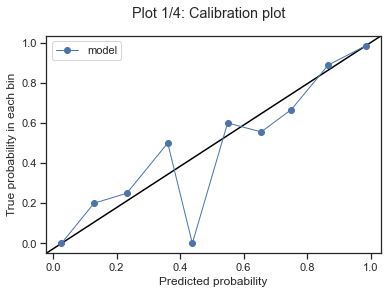

No handles with labels found to put in legend.


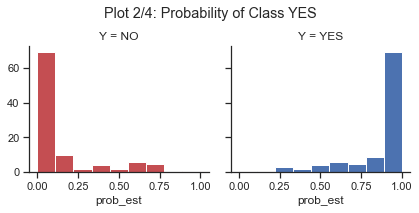

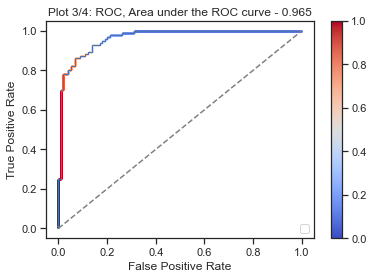

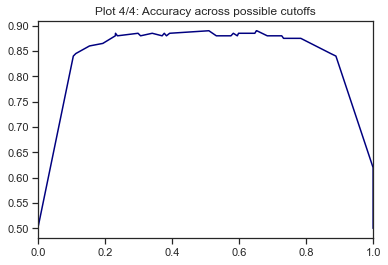

In [29]:
CT.plotClassPerformance(dfTS_eval['Y'], SVC_fit.predict_proba(X_test)[:,1], selClass='YES')